The analysis of the experiment data is also accessible online: [https://github.com/NormandErwan/HandheldVesadAnalysis/blob/master/Handheld%20VESAD%20Analysis.ipynb](https://github.com/NormandErwan/HandheldVesadAnalysis/blob/master/Handheld%20VESAD%20Analysis.ipynb).

## 1. Data preparation

Configuration :

In [1]:
# Imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import itertools

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (MultiComparison, pairwise_tukeyhsd)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng

from ast import literal_eval
from os import listdir
from os.path import join

from IPython.html.services.config import ConfigManager

C:\Users\Erwan\Miniconda\envs\master-thesis\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Notebook configuration
%matplotlib inline

# Ruler
ip = get_ipython()
cm = ConfigManager(parent=ip)
cm.update('notebook', {"ruler_column": [80]})

# Style and size of the figures
subplotsize = (5, 4)
legend_fontsize = sns.plotting_context('notebook')['axes.labelsize']
legend_title_fontsize = legend_fontsize + 1
sns.set(context='notebook', style='whitegrid', font_scale=1.25,
        rc={'legend.fontsize': legend_fontsize, 'savefig.dpi': 300,
            'savefig.bbox': 'tight'})

# Render the plots with this language
language = 'English'
#language = 'Français'

Data are loaded in the following variables:
- Participants information, from the questionary before the trials: `participants`
- The summary of the trials of the participants: `raw_trials`
- Trials averaged so that each participants ends up with a single observation (there was two trials per condition per participant) (Tip 9 of Dragicevic (2016)) : `trials`
- The detailed measures of the trials: `trial_details`
- The ranks of the participants from the post-questionary: `ranks`

In [3]:
participants = pd.read_csv('participants.csv')
trials = pd.read_csv('participant_trials.csv')
raw_trials = pd.read_csv('participant_trials.csv')
ranks = pd.read_csv('participant_ranks.csv')

In [4]:
# Detailled trials are long to load, keep commented if unused

#trial_details = []
#for file in listdir('.'):
#    if file.endswith('details.csv'): # The trial files end with *-details.csv
#        details.append(pd.read_csv(file))
#trial_details = pd.concat(details, ignore_index=True)

Creates independent variables lists (`participants_ivs`, `trials_ivs`) and dependent variables lists (`ranks_dvs`, `trials_dvs`) to make easier to use algorithms and to plot figures.

In [5]:
# Participants IVs
if language == 'Français':
    participants_iv_labels = ['Participant', 'Sexe', 'Porte des lunettes',
                              'Porte des lentilles', 'Est daltonien',
                              'Intervalle d\'âge', 'Main dominante',
                              'Main utilisée pour la souris',
                              'Activité principale',
                              'Utilisation de l\'ordinateur (heures/jours)',
                              'Logiciels 3D utilisés',
                              'Visiocasques RV/RA utilisés',
                              'Techniques d\'interactions RV/RA utilisées']
else:
    participants_iv_labels = ['Participant', 'Sex', 'Has Glasses',
                              'Has Contact Lenses', 'Is Color Blind',
                              'Age Class', 'Dominant Hand',
                              'Hand Used for Mouse', 'Activity',
                              'Computer Hours per Day', '3D Softwares Used',
                              'HMD Used',
                              'Known Interactions Techniques on HMD']

participants_ivs = pd.Series(data=participants_iv_labels,
                             index=participants.columns)

In [6]:
# Trials IVs
if language == 'Français':
    trials_iv_labels = ['Technique', 'Taille du texte', 'Distance', 'Groupe']
else:
    trials_iv_labels = ['Technique', 'Text Size', 'Distance', 'Ordering']

trials_ivs = ['technique', 'text_size', 'distance', 'ordering']
trials_ivs = pd.DataFrame(columns=trials_ivs, index=['label', 'categorical',
                                                     'palette'])

palette = sns.color_palette('Set2', 8)

for iv_index, iv_label in zip(trials_ivs.columns, trials_iv_labels):
    iv_categories = trials.sort_values([iv_index + '_id'])\
    .drop_duplicates(iv_index)[iv_index]
    iv_categorical = pd.Categorical(iv_categories, iv_categories, ordered=True)
    trials_ivs[iv_index] = [iv_label, iv_categorical, palette]

technique_palette = [palette[1], palette[0], palette[2]]
trials_ivs.at['palette', 'technique'] = technique_palette
trials_ivs.at['palette', 'text_size'] = sns.light_palette(palette[6], 3)[1:3]
trials_ivs.at['palette', 'distance'] = sns.light_palette(palette[4], 3)[1:3]
trials_ivs.at['palette', 'ordering'] = technique_palette

In [7]:
# Trials DVs
if language == 'Français':
    trials_dv_labels = ['Temps de complétion (s)', 'Sélections',
                        'Temps en sélection', 'Distance 3D en sélection',
                        'Distance en sélection', 'Déselections', 'Erreurs',
                        'Disques classés', 'Défilements', 'Temps de défilement',
                        'Distance 3D de défilement', 'Distance de défilement',
                        'Zooms', 'Temps de zoom', 'Distance 3D de zoom',
                        'Distance de zoom', 'Mouvements tête-téléphone',
                        'Distance relative tête-téléphone']
else:
    trials_dv_labels = ['Task Completion Time (s)', 'Selections',
                        'Selection Time', 'Selection Distance',
                        'Selection Distance on Grid', 'Deselections', 'Errors',
                        'Items Classified', 'Pans', 'Pan Time', 'Pan Distance',
                        'Pan Distance on Grid', 'Zooms', 'Zoom Time',
                        'Zoom Distance', 'Zoom Distance on Grid',
                        'Phone-Head Motion', 'Signed Phone-Head Motion']

trials_dvs = trials.loc[:, 'total_time':'signed_head_phone_distance'].columns
trials_dvs = pd.Series(data=trials_dv_labels, index=trials_dvs)

In [8]:
# Ranks DVs
if language == 'Français':
    ranks_dv_labels = ['Facile à comprendre', 'Mentalement facile à utiliser',
                       'Physiquement facile à utiliser', 'Rapidité', 'Réussite',
                       'Frustration', 'Préférence']
else:
    ranks_dv_labels = ['Easy to Understand', 'Mentally Easy to Use',
                       'Physically Easy to Use', 'Subjective Speed',
                       'Subjective Performance', 'Frustration', 'Preference']

ranks_dv_scales = [pd.Categorical(list(range(1, 6)), list(
    range(1, 6)), ordered=True)] * len(ranks_dv_labels)

RdYlBu = sns.color_palette('RdYlBu', 5)
ranks_dv_palettes = [sns.color_palette('RdYlBu', 5)] * len(ranks_dv_labels)

ranks_dvs = ranks.loc[:, 'easy_understand':'preference'].columns
ranks_dvs = pd.DataFrame(data=[ranks_dv_labels, ranks_dv_scales,
                               ranks_dv_palettes],
                         columns=ranks_dvs, index=['label', 'scale', 'palette'])

ranks_dvs.at['scale', 'preference'] = pd.Categorical(
    list(range(1, 4)), list(range(1, 4)), ordered=True)
ranks_dvs.at['palette', 'preference'] = [RdYlBu[4], RdYlBu[2], RdYlBu[0]]

In [9]:
# Shortcuts
participant_id = participants_ivs['participant_id']
technique = trials_ivs['technique']
text_size = trials_ivs['text_size']
distance = trials_ivs['distance']
ordering = trials_ivs['ordering']

total_time = trials_dvs['total_time']

Clean the data:

In [10]:
# Set better and translated columns to participants, trials and ranks
participants.columns = participants_ivs

columns = []
for column in trials.columns:
    if (column in participants_ivs.index):
        columns.append(participants_ivs[column])
    elif (column in trials_ivs.columns):
        columns.append(trials_ivs[column]['label'])
    elif (column in trials_dvs.index):
        columns.append(trials_dvs[column])
    else:
        columns.append(column)

trials.columns = columns

ranks.columns = [participant_id, ordering['label'],
                 technique['label']] + ranks_dvs.loc['label', :].tolist()

In [11]:
# Set the participant_id column as the index in participants
participants.set_index(participants_ivs['participant_id'], inplace=True)

In [12]:
# Some participants are non valid or don't have complete measures
del_parti = [0, 4]

participants = participants[~participants.index.isin(del_parti)]
ranks = ranks[~ranks[participant_id].isin(del_parti)].reset_index(drop=True)

trials = trials[~trials[participant_id].isin(del_parti)].reset_index(drop=True)
raw_trials = raw_trials[~raw_trials['participant_id'].isin(del_parti)
                       ].reset_index(drop=True)

In [13]:
# Some participants have wrong head phone mesures
for head_distance_column in ['absolute_head_phone_distance',
                             'signed_head_phone_distance']:
    trials.loc[trials[trials_dvs[head_distance_column]] == 0,
               trials_dvs[head_distance_column]] = np.nan
    raw_trials.loc[raw_trials[head_distance_column] == 0,
                   head_distance_column] = np.nan

In [14]:
# Setup categorical columns participants, trials and ranks
participants[ordering['label']] = ranks.groupby(participant_id)\
                                        [ordering['label']].first()
participants[ordering['label']] = participants[ordering['label']]\
                                    .astype(ordering['categorical'])

for iv_index in trials_ivs.columns:
    iv = trials_ivs[iv_index]
    trials[iv['label']] = trials[iv['label']].astype(iv['categorical'])
    raw_trials[iv_index] = trials[iv['label']]

ranks[technique['label']] = ranks[technique['label']]\
                            .astype(technique['categorical'])
ranks[ordering['label']] = ranks[ordering['label']]\
                           .astype(ordering['categorical'])

# Rename categories
if language == 'Français':
    technique['categorical'].categories = ['Téléphone', 'VESAD tactile', 'VESAD']
    text_size['categorical'].categories = ['Grand', 'Petit']
    distance['categorical'].categories = ['Proche', 'Loin']
    ordering['categorical'].categories = ['Groupe 1', 'Groupe 2', 'Groupe 3']
else:
    ordering['categorical'].categories = ['Group 1', 'Group 2', 'Group 3']

# Set renamed categories to data
participants[trials_ivs['ordering']['label']].cat.categories\
    = ordering['categorical'].categories

for iv_index in trials_ivs.columns:
    iv = trials_ivs[iv_index]
    trials[iv['label']].cat.categories = iv['categorical'].categories

ranks[technique['label']].cat.categories = technique['categorical'].categories
ranks[ordering['label']].cat.categories = ordering['categorical'].categories

In [15]:
# Eval the arrays in some dvs
def eval_if_str(data):
    return literal_eval(data) if isinstance(data, str) else data

trials['grid_config'] = trials['grid_config'].apply(eval_if_str)

In [16]:
# Average trials to one observation per participant
trials = trials.groupby([participant_id] + trials_ivs.loc['label', :].tolist(),
                        observed=True).mean().reset_index()
raw_trials = raw_trials.groupby(['participant_id'] + trials_ivs.columns.tolist(),
                        observed=True).mean().reset_index()

Utilities:

In [17]:
# Figure labels in the selected language
labels = pd.Series()

if language == 'Français':
    labels['category'] = 'Catégorie'
    labels['count'] = 'Nombre total'
    labels['distance'] = 'Distance moyenne (m)'
    labels['dv'] = 'VD'
    labels['iv'] = 'VI'
    labels['iv_value'] = 'Valeur VI'
    labels['mean_difference'] = 'Différence des moyennes'
    labels['mean_difference_percentage'] = 'Différence des moyennes (%)'
    labels['mean_rank'] = 'Note moyenne'
    labels['preferences'] = ['Premier', 'Deuxième', 'Troisième']
    labels['p_value'] = 'Valeur p'
    labels['question'] = 'Question'
    labels['rank'] = 'Note'
    labels['time'] = 'Temps moyen (s)'
    labels['t_statistic'] = 'Statistique T'
    labels['votes'] = 'Participants'
else:
    labels['category'] = 'Category'
    labels['count'] = 'Count'    
    labels['distance'] = 'Mean Distance (m)'
    labels['dv'] = 'DV'
    labels['iv'] = 'IV'
    labels['iv_value'] = 'IV Value'
    labels['mean_difference'] = 'Mean Difference'
    labels['mean_difference_percentage'] = 'Mean Difference Percentage'
    labels['mean_rank'] = 'Mean Rank'
    labels['preferences'] = ['First', 'Second', 'Third']
    labels['p_value'] = 'p-value'
    labels['question'] = 'Question'
    labels['rank'] = 'Rank'
    labels['time'] = 'Mean Time (s)'
    labels['t_statistic'] = 'T statistic'
    labels['votes'] = 'Participants'

In [18]:
def mean_ci(x, which=95, n_boot=1000):
    """Returns the confidence interval of the mean"""
    x2 = [i for i in x if not np.isnan(i)]
    boots = sns.algorithms.bootstrap(x2, n_boot=n_boot)
    return sns.utils.ci(boots, which=which)

In [19]:
def print_mean_ci(x, ci_which=95):
    """Returns a string containing the mean with the CI of x"""
    ci1, ci2 = mean_ci(x, which=ci_which)
    return '{:.2f} [{:.2f}, {:.2f}]'.format(np.mean(x), ci1, ci2)

In [20]:
def exp_mean(x):
    return np.exp(np.mean(x))

In [21]:
def print_exp_mean_ci(x, ci_which=95):
    ci1, ci2 = np.exp(mean_ci(x, which=ci_which))
    return '{:.2f} [{:.2f}, {:.2f}]'.format(np.exp(np.mean(x)), ci1, ci2)

In [22]:
def mean_difference(a, b):
    """Returns the mean difference value and percentage between a and b"""
    mean_diff = np.mean(a) - np.mean(b)
    mean_diff_percentage = mean_diff / np.mean(b) * 100
    return (mean_diff, mean_diff_percentage)

In [23]:
def p_values_correction(data, alpha=0.05, correction_method='fdr_bh'):
    if correction_method != None:
        reject, p_values_corrected, a1, a2 =\
            multipletests(data[labels['p_value']].tolist(), alpha=alpha,
                          method=correction_method)
        data[labels['p_value']] = p_values_corrected

In [24]:
def subplots(nsubplots, ncols_max=2, subplotsize=subplotsize, *plt_args):
    ncols = min(ncols_max, nsubplots)
    nrows = ((nsubplots - 1) // ncols) + 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,\
                            figsize=(subplotsize[0]*ncols, subplotsize[1]*nrows),
                            *plt_args)

    if nrows == 1 and ncols == 1:
        axs = [axs]
    elif nrows >= 2 and ncols >= 2:
        axs = [ax for ax_row in axs for ax in ax_row]

    for ax in axs[::-1][0:len(axs) - nsubplots]:
        fig.delaxes(ax)

    return (fig, axs)

In [25]:
def fix_legend_fontsize(ax_legend, fontsize=legend_title_fontsize):
    plt.setp(ax_legend.get_title(), fontsize=fontsize)

In [26]:
def config_legend(ax, iv_id, fontsize=legend_title_fontsize):
    legend = ax.legend(title=trials_ivs.at['label', iv_id], frameon=True,
                       loc='center left', bbox_to_anchor=(1, 0.5))
    fix_legend_fontsize(legend)
    return legend

## 2. Participant ranks

Some functions for the analysis:

In [27]:
def get_ranks_count(iv_index, dv_index):
    iv, dv = trials_ivs[iv_index], ranks_dvs[dv_index]
    
    ranks_counts_index = pd.MultiIndex.from_product([iv['categorical'],
                                                     dv['scale']],
                                                    names=[iv['label'],
                                                           labels['rank']])
    # Zero counts by default and gets the counts
    default_counts = pd.Series(0, index=ranks_counts_index)
    ranks_counts = ranks.groupby([iv['label'], dv['label']]).size() 
    
    # Merge and remove duplicated defaults
    ranks_counts = pd.concat([ranks_counts, default_counts]) 
    ranks_counts = ranks_counts[~ranks_counts.index.duplicated(keep='first')]
    
    ranks_counts.sort_index(inplace=True)
    ranks_counts.index = ranks_counts_index # Restore the index
    return ranks_counts

In [28]:
def cumulated_barplot(data, palette, **args):
    for row_id, row in data.iloc[::-1].iterrows():
        sns.barplot(y=data.columns, x=row, label=row_id,
                    color=palette[row_id-1], orient='h', **args)

In [29]:
def plot_ranks_distributions(iv_id, dv_ids):
    iv = trials_ivs[iv_id]
    
    fig, axs = subplots(len(dv_ids))
    for dv_id, ax in zip(dv_ids, axs):
        dv = ranks_dvs[dv_id]

        cumulated_ranks_count = get_ranks_count(iv_id, dv_id).unstack(level=0)\
                                .cumsum()
        cumulated_barplot(cumulated_ranks_count, palette=dv['palette'], ax=ax)
        ax.set(xlabel=labels['votes'], xlim=(0, cumulated_ranks_count.max()[0]))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2)) # Fix the axis ticks

        ax_handles, ax_labels = ax.get_legend_handles_labels()
        legend = ax.legend(ax_handles[::-1], ax_labels[::-1], frameon=True,
                           loc='lower center', bbox_to_anchor=(0.5, 1),
                           mode=None, ncol=len(dv['scale']), title=dv['label'],
                           fontsize=legend_fontsize-2)
        fix_legend_fontsize(legend)
        
    fig.tight_layout(h_pad=1) # Add padding to avoir legend and labels overlap
    return (fig, axs)

In [30]:
def plot_ranks(iv_id, dv_ids, estimator=np.mean):
    iv = trials_ivs[iv_id]
    
    fig, axs = subplots(len(dv_ids))
    for dv_id, ax in zip(dv_ids, axs):
        dv = ranks_dvs[dv_id]

        sns.barplot(x=iv['label'], y=dv['label'], palette=iv['palette'],
                    data=ranks, ax=ax, estimator=estimator)
        ax.set(ylim=(0, dv['scale'][-1]))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) # Fix the axis ticks
        
    return (fig, axs)

In [31]:
def rank_samples(iv_id, dv_id):
    """Returns the list of ranks (DV) for each IV value"""
    samples = []
    iv = trials_ivs[iv_id]
    for iv_value in iv['categorical']:
        dv_label = ranks_dvs[dv_id]['label']
        sample = ranks[ranks[iv['label']] == iv_value][dv_label]\
                 .reset_index(drop=True)
        samples.append(sample)
    return samples

In [32]:
def test_ranks(iv_id, dv_ids, **args):
    results = []
    iv = trials_ivs[iv_id]
    
    for dv_id in dv_ids:
        dv = ranks_dvs[dv_id]
        samples = rank_samples(iv_id, dv_id)
        H, p = stats.kruskal(*samples)
        results.append([iv['label'], dv['label'], H, p])

    results = pd.DataFrame(results, columns=[labels['iv'], labels['dv'],
                                             'Kruskal-Wallis H',
                                             labels['p_value']])
    p_values_correction(results, **args)
    return results

In [33]:
def test_pairwise_ranks(iv_id, dv_ids, **args):
    iv = trials_ivs[iv_id]
    iv_category_ids = range(len(iv['categorical']))
    
    results = []
    for dv_id in dv_ids:
        dv = ranks_dvs[dv_id]
        samples = rank_samples(iv_id, dv_id)
        sample_pairs = itertools.combinations(iv_category_ids, 2)
        for id1, id2 in sample_pairs:
            U, p = stats.mannwhitneyu(samples[id1], samples[id2])
            mean_diff, mean_diff_per = mean_difference(samples[id1], samples[id2])
            results.append([iv['label'], iv['categorical'][id1],
                            iv['categorical'][id2], dv['label'],
                            mean_diff, mean_diff_per, U, p])

    columns = [labels['iv'], labels['iv_value'] + ' 1', 
               labels['iv_value'] + ' 2', labels['dv'],
               labels['mean_difference'], labels['mean_difference_percentage'],
               'Mann-Whitney U', labels['p_value']]
    results = pd.DataFrame(results, columns=columns)
    p_values_correction(results, **args)
    return results

We display the rank and preference distributions:

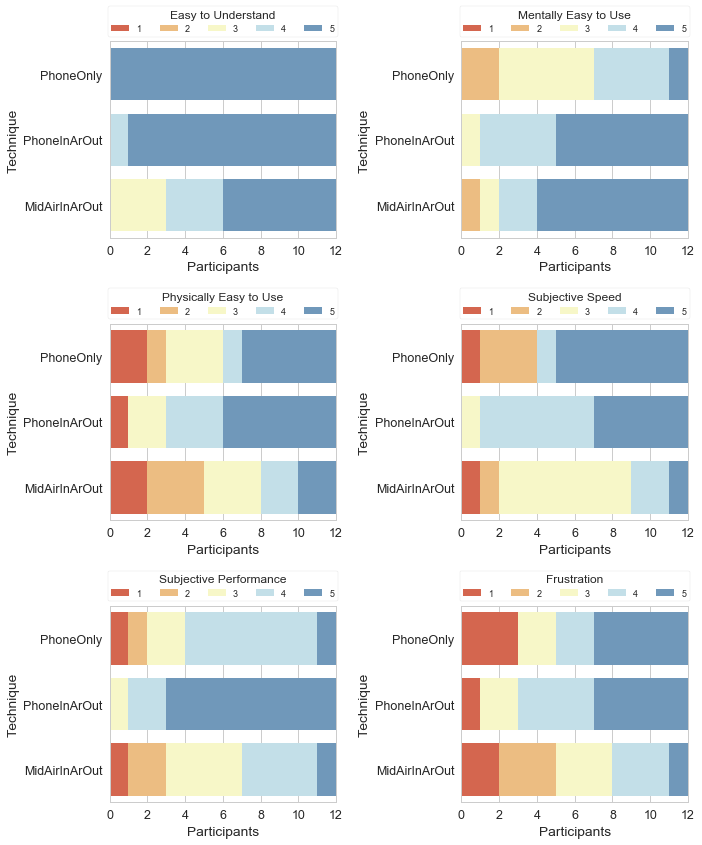

In [34]:
(fig, axs) = plot_ranks_distributions('technique', ranks_dvs.columns[0:-1])
fig.savefig('ranks_distributions.png')

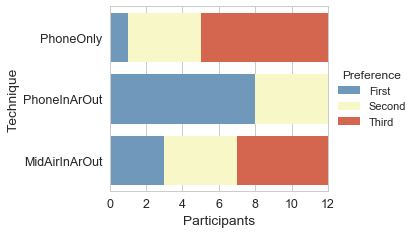

In [35]:
(fig, axs) = plot_ranks_distributions('technique', ['preference'])

ax_handles, ax_labels = axs[0].get_legend_handles_labels()
legend = axs[0].legend(ax_handles[::-1], labels['preferences'],
                       loc='center left', bbox_to_anchor=(1, 0.5),
                       title=ranks_dvs['preference']['label'])
fix_legend_fontsize(legend)

fig.savefig('preferences_distribution.png')

We use the Kruskal-Wallis test (Benjamini–Hochberg correction) on each question to check if there is statistical significative differences between the ranks among TECHNIQUE:

In [36]:
test_ranks('technique', ranks_dvs, correction_method='fdr_bh')

,IV,DV,Kruskal-Wallis H,p-value
0,Technique,Easy to Understand,11.001420,0.007497
1,Technique,Mentally Easy to Use,10.905742,0.007497
2,Technique,Physically Easy to Use,4.148121,0.125674
3,Technique,Subjective Speed,7.130846,0.039599
4,Technique,Subjective Performance,13.784269,0.006303
5,Technique,Frustration,4.500057,0.122962
6,Technique,Preference,12.638889,0.006303


All the questions, except Physically Easy to Use and Frustration, are statistically significants: Easy to Understand ($p=0.007$), Mentally Easy to Use ($p=0.007$), Subjective Speed ($p=0.04$), Subjective Performance ($p=0.006$), Preference ($p=0.006$).

We use then pairwise Mann-Whitney tests (Benjamini–Hochberg correction) for the significant questions above:

In [37]:
test_pairwise_ranks('technique', ['easy_understand', 'mentally_easy_use',
                                  'could_go_fast', 'subjective_performance',
                                  'preference'], correction_method='fdr_bh')

,IV,IV Value 1,IV Value 2,DV,Mean Difference,Mean Difference Percentage,Mann-Whitney U,p-value
0,Technique,PhoneOnly,PhoneInArOut,Easy to Understand,0.083333,1.694915,66.0,0.215732
1,Technique,PhoneOnly,MidAirInArOut,Easy to Understand,0.750000,17.647059,36.0,0.008605
2,Technique,PhoneInArOut,MidAirInArOut,Easy to Understand,0.666667,15.686275,40.5,0.020977
3,Technique,PhoneOnly,PhoneInArOut,Mentally Easy to Use,-1.166667,-25.925926,23.0,0.005031
4,Technique,PhoneOnly,MidAirInArOut,Mentally Easy to Use,-1.083333,-24.528302,28.5,0.010151
5,Technique,PhoneInArOut,MidAirInArOut,Mentally Easy to Use,0.083333,1.886792,69.5,0.475027
6,Technique,PhoneOnly,PhoneInArOut,Subjective Speed,-0.500000,-11.538462,70.5,0.475027
7,Technique,PhoneOnly,MidAirInArOut,Subjective Speed,0.750000,24.324324,48.5,0.126838
8,Technique,PhoneInArOut,MidAirInArOut,Subjective Speed,1.250000,40.540541,21.0,0.004655
9,Technique,PhoneOnly,PhoneInArOut,Subjective Performance,-1.166667,-25.000000,22.5,0.004655


We display the mean and 95% CI of each question:

In [38]:
ranks.groupby([trials_ivs['technique']['label']])\
     .aggregate(print_mean_ci).loc[:, ranks_dvs.loc['label', :]].transpose()

Technique,PhoneOnly,PhoneInArOut,MidAirInArOut
Easy to Understand,"5.00 [5.00, 5.00]","4.92 [4.75, 5.00]","4.25 [3.83, 4.67]"
Mentally Easy to Use,"3.33 [2.83, 3.75]","4.50 [4.08, 4.83]","4.42 [3.83, 4.92]"
Physically Easy to Use,"3.50 [2.67, 4.33]","4.08 [3.33, 4.67]","2.92 [2.25, 3.67]"
Subjective Speed,"3.83 [3.00, 4.67]","4.33 [4.00, 4.67]","3.08 [2.50, 3.67]"
Subjective Performance,"3.50 [2.91, 4.00]","4.67 [4.25, 5.00]","3.17 [2.58, 3.75]"
Frustration,"3.50 [2.58, 4.33]","4.00 [3.25, 4.58]","2.83 [2.17, 3.50]"
Preference,"2.50 [2.08, 2.83]","1.33 [1.08, 1.58]","2.17 [1.75, 2.67]"


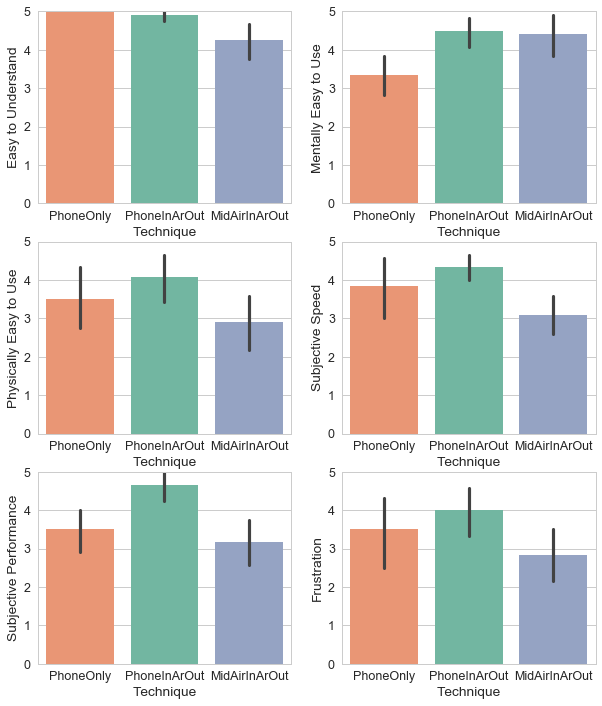

In [39]:
(fig, axs) = plot_ranks('technique', ranks_dvs.columns[0:-1])
fig.savefig('ranks.png')

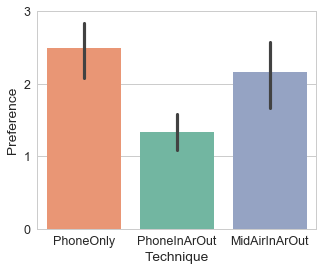

In [40]:
(fig, axs) = plot_ranks('technique', ['preference'])
fig.savefig('preferences.png')

Overall significant results are:

- **Easy to Understand**: *PhoneOnly* is significantly better than *MidAirInArOut* ($p = 0.009$), and seems a little better than *PhoneInArOut*.
- **Physically Easy to Use**: There is no significant differences due to TECHNIQUE; they seem scored similar.
- **Mentally Easy to Use**: *PhoneOnly* is statistically and practically worst than *PhoneInArOut* ($p = 0.005$) and *MidAirInArOut* ($p = 0.01$).
- **Subjective Speed**: *PhoneInArOut* is significantly better than *MidAirInArOut* ($p = 0.05$).
- **Subjective Performance**: *PhoneInArOut* is statistically better than *PhoneOnly* ($p = 0.005$) and *MidAirInArOut* ($p = 0.004$).
- **Frustration**: There is no significant differences due to  TECHNIQUE; they seem scored similar.
- **Preference**: *PhoneInArOut* is significantly prefered to *PhoneOnly* ($p = 0.004$) and *MidAirInArOut* ($p = 0.01$).

## 3. Participant trials

Some functions for the analysis:

In [41]:
def trial_samples(iv_id, dv_id, data=trials):
    iv, dv = trials_ivs[iv_id], trials_dvs[dv_id]
    return [data[data[iv['label']] == iv_value][dv]\
            for iv_value in iv['categorical']]

In [42]:
def trial_means(iv_ids, dv_ids, data=trials, aggregate=print_mean_ci):
    iv_labels = [trials_ivs.at['label', iv_id] for iv_id in iv_ids]
    dv_labels = [trials_dvs[dv_id] for dv_id in dv_ids]
    return data[iv_labels + dv_labels].groupby(iv_labels)\
                                      .aggregate(aggregate)

In [43]:
def melt_trials(value_vars, var_name, value_name, data=trials):
    return pd.melt(data, id_vars=trials_ivs.loc['label', :],
                   value_vars=value_vars, var_name=var_name,
                   value_name=value_name)

In [44]:
def test_normality(iv_ids, dv_ids, data=trials, **args):
    results = []
    
    for dv_id in dv_ids:
        for iv_id in iv_ids:
            iv = trials_ivs[iv_id]
            samples = trial_samples(iv_id, dv_id, data)
            for iv_value, sample in zip(iv['categorical'], samples):
                W, p = stats.shapiro(sample)
                results.append([iv['label'], iv_value, trials_dvs[dv_id], W, p])

    results = pd.DataFrame(results, columns=[labels['iv'], labels['iv_value'],
                                             labels['dv'], 'Shapiro W',
                                             labels['p_value']])
    p_values_correction(results, **args)
    return results

In [45]:
def test_equal_variances(iv_ids, dv_ids, data=trials, levene_center='mean',
                         **args):
    results = []
    
    for dv_id in dv_ids:
        for iv_id in iv_ids:
            samples = trial_samples(iv_id, dv_id, data)
            W, p = stats.levene(*samples)
            results.append([trials_ivs.at['label', iv_id], trials_dvs[dv_id],
                            W, p])

    results = pd.DataFrame(results, columns=[labels['iv'], labels['dv'],
                                             'Levene W', labels['p_value']])
    p_values_correction(results, **args)
    return results

In [46]:
def test_pairwise_trials(iv_id, dv_id, data=trials, log_data=False, **args):
    results = []
    iv, dv = trials_ivs[iv_id], trials_dvs[dv_id]
    iv_category_ids = range(len(iv['categorical']))
    
    samples = trial_samples(iv_id, dv_id, data)
    sample_pairs = itertools.combinations(iv_category_ids, 2)
    for id1, id2 in sample_pairs:
        T, p = stats.ttest_ind(samples[id1], samples[id2])
        
        mean_diff, mean_diff_per = mean_difference(np.exp(samples[id1]),
                                                   np.exp(samples[id2]))\
            if log_data else mean_difference(samples[id1], samples[id2])
        
        results.append([iv['label'], iv['categorical'][id1],
                        iv['categorical'][id2], dv, mean_diff,
                        mean_diff_per, T, p])

    columns = [labels['iv'], labels['iv_value'] + ' 1',
               labels['iv_value'] + ' 2', labels['dv'],
               labels['mean_difference'], labels['mean_difference_percentage'],
               labels['t_statistic'], labels['p_value']]
    results = pd.DataFrame(results, columns=columns)

    p_values_correction(results, **args)
    return results

In [47]:
def test_non_normal_trials(iv_ids, dv_ids, data=trials, **args):
    results = []
    
    for dv_id in dv_ids:
        for iv_id in iv_ids:
            samples = trial_samples(iv_id, dv_id, data)
            H, p = stats.kruskal(*samples)
            results.append([trials_ivs.at['label', iv_id], trials_dvs[dv_id],
                            H, p])

    results = pd.DataFrame(results, columns=[labels['iv'], labels['dv'],
                                             'Kruskal-Wallis H',
                                             labels['p_value']])
    p_values_correction(results, **args)
    return results

In [48]:
def test_pairwise_non_normal_trials(iv_ids, dv_ids, data=trials, **args):
    results = []
    
    for dv_id in dv_ids:
        for iv_id in iv_ids:
            iv, dv = trials_ivs[iv_id], trials_dvs[dv_id]
            samples = trial_samples(iv_id, dv_id, data)
        
            iv_category_ids = range(len(iv['categorical']))
            sample_pairs = itertools.combinations(iv_category_ids, 2)
            for id1, id2 in sample_pairs:
                U, p = stats.mannwhitneyu(samples[id1], samples[id2])
                mean_diff, mean_diff_per = mean_difference(samples[id1],
                                                           samples[id2])
                results.append([iv['label'], iv['categorical'][id1],
                                iv['categorical'][id2], dv, mean_diff,
                                mean_diff_per, U, p])

    columns = [labels['iv'], labels['iv_value'] + ' 1', 
               labels['iv_value'] + ' 2', labels['dv'],
               labels['mean_difference'], labels['mean_difference_percentage'],
               'Mann-Whitney U', labels['p_value']]
    results = pd.DataFrame(results, columns=columns)
    p_values_correction(results, **args)
    return results

In [49]:
def plot_trials(iv_ids_list, dv_id, data=trials, kind='bar', **args):
    dv = trials_dvs[dv_id]
    if (len(iv_ids_list) == 0):
        iv_ids_list = [[iv_id] for id_id in trials_ivs.columns]
        
    fig, axs = subplots(len(iv_ids_list))
    for id_ids, ax in zip(iv_ids_list, axs):
        
        ivs = [trials_ivs[id_id] for id_id in id_ids]
        if (len(ivs) == 1):
            iv = ivs[0]
            
            if (kind == 'bar'):
                sns.barplot(x=iv['label'], y=dv, data=data,
                            palette=iv['palette'], ax=ax, **args)
                
            elif (kind == 'box'):
                sns.boxplot(x=iv['label'], y=dv, data=data,
                            palette=iv['palette'], ax=ax, **args)
                
            elif (kind == 'count'):
                sns.countplot(hue=iv['label'], x=dv, data=data,
                              palette=iv['palette'], ax=ax, **args)
                ax.set(ylabel='Count')
                ax.legend(loc='upper right', title=labels['count'],
                          frameon=True)
            
        elif (len(ivs) == 2):
            if (kind == 'bar'):
                sns.barplot(x=ivs[1]['label'], y=dv, hue=ivs[0]['label'],
                            data=data, palette=ivs[0]['palette'], ax=ax, **args)
            ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1, 1))
            
    return (fig, axs)

### 3.1. Task completion time

We first apply a log transform to TCT to approximate a normal distribution.

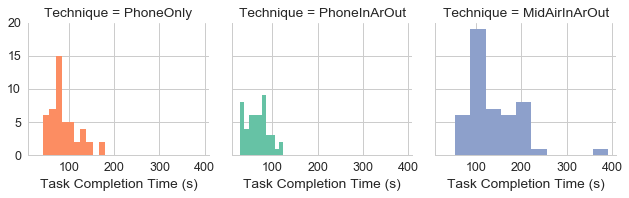

In [50]:
g = sns.FacetGrid(trials, col=technique['label'], hue=technique['label'],
                 palette=technique['palette'])
g = g.map(plt.hist, total_time)
g.savefig('tct_distributions.png')

In [51]:
trials[total_time] = np.log(trials[total_time])
raw_trials['total_time'] = np.log(raw_trials['total_time'])

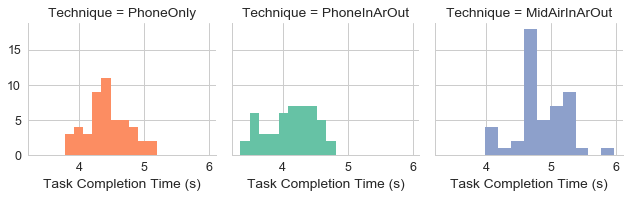

In [52]:
g = sns.FacetGrid(trials, col=technique['label'], hue=technique['label'],
                 palette=technique['palette'])
g = g.map(plt.hist, total_time)
g.savefig('tct_distributions_log.png')

We test the normality of TCT distributions for each TECHNIQUE and their equality of variances, since it's the main factor of interest.

In [53]:
test_normality(['technique'], ['total_time'])

,IV,IV Value,DV,Shapiro W,p-value
0,Technique,PhoneOnly,Task Completion Time (s),0.983679,0.735995
1,Technique,PhoneInArOut,Task Completion Time (s),0.971828,0.446912
2,Technique,MidAirInArOut,Task Completion Time (s),0.966510,0.446912


In [54]:
test_equal_variances(['technique'], ['total_time'])

,IV,DV,Levene W,p-value
0,Technique,Task Completion Time (s),0.756269,0.471309


We meet all the assumptions of an ANOVA. Trials were done independently, TCT distributions are normal and their variances are equal.

We perform a full factorial ANOVA with the model: TCT ~ TECHNIQUE x TEXT_SIZE x DISTANCE + TECHNIQUE x ORDERING.

In [55]:
tct_model = ols('total_time ~ technique * text_size * distance'
                + '+ technique * ordering', data=raw_trials).fit()
sm.stats.anova_lm(tct_model, typ=2)

,sum_sq,df,F,PR(>F)
technique,12.328279,2.0,62.210952,1.610604e-19
text_size,0.145175,1.0,1.465169,2.283752e-01
distance,0.029459,1.0,0.297314,5.865353e-01
ordering,2.133256,2.0,10.764832,4.829976e-05
technique:text_size,0.398420,2.0,2.010508,1.381943e-01
technique:distance,0.074854,2.0,0.377730,6.861892e-01
text_size:distance,0.291976,1.0,2.946742,8.850822e-02
technique:ordering,3.086868,4.0,7.788476,1.215733e-05
technique:text_size:distance,0.499563,2.0,2.520896,8.443561e-02
Residual,12.484644,126.0,NaN,NaN


The main significant effect on TCT is TECHNIQUE ($F=62.2$, $p<0.0001$), then ORDERING ($F=10.8$, $p<0.0001$). There is also an significant interaction effect: TECHNIQUE x ORDERING ($F=2.5$, $p<0.0001$).

We display mean TCT values with 95% CI for these conditions:

In [56]:
trial_means(['technique'], ['total_time'], aggregate=print_exp_mean_ci)

,Task Completion Time (s)
Technique,
PhoneOnly,"84.02 [76.49, 92.29]"
PhoneInArOut,"62.59 [56.17, 69.55]"
MidAirInArOut,"127.71 [114.61, 142.79]"


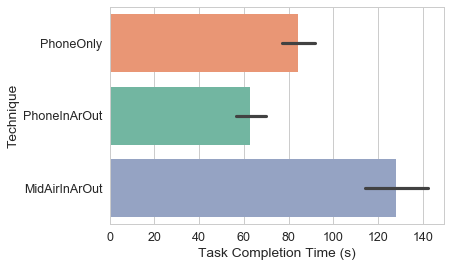

In [57]:
ax = sns.barplot(x=trials_dvs['total_time'], y=technique['label'],
                 palette=technique['palette'], data=trials, estimator=exp_mean)
ax.get_figure().savefig('tct.png')

In [58]:
trial_means(['ordering', 'technique'], ['total_time'],
            aggregate=print_exp_mean_ci).unstack()

Task Completion Time (s)                        \
Technique                PhoneOnly          PhoneInArOut   
Ordering                                                   
Group 1     107.14 [92.53, 124.69]  73.63 [66.87, 80.71]   
Group 2       76.22 [65.86, 87.04]  78.79 [68.67, 89.26]   
Group 3       72.64 [64.28, 81.87]  42.27 [37.74, 47.54]   

                                    
Technique            MidAirInArOut  
Ordering                            
Group 1    124.00 [107.36, 142.70]  
Group 2    125.91 [100.74, 151.03]  
Group 3    133.41 [107.95, 166.24]

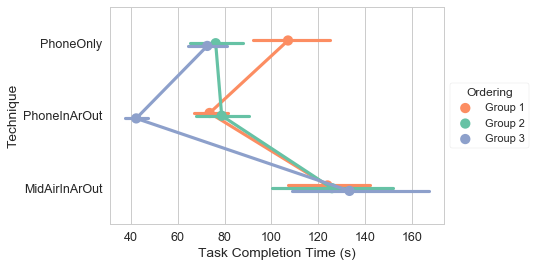

In [59]:
ax = sns.pointplot(x=trials_dvs['total_time'], y=technique['label'],
                  hue=ordering['label'], palette=ordering['palette'],
                  data=trials, dodge=True, estimator=exp_mean)
config_legend(ax, 'ordering')
ax.get_figure().savefig('tct_ordering.png')

It seems that participants who started with *PhoneOnly* were slower with this technique than the the other groups. Similarly, participants who finished with *PhoneInArOut* were faster with this technique. It indicates there is a learning curve on the task, but interestingly participants from all groups performed equally with *MidAirInArOut* technique.

We compare the TCT for the three techniques only with pairwise t-tests (Benjamini–Hochberg correction) .

In [60]:
test_pairwise_trials('technique', 'total_time', correction_method='fdr_bh',
                     log_data=True)

,IV,IV Value 1,IV Value 2,DV,Mean Difference,Mean Difference Percentage,T statistic,p-value
0,Technique,PhoneOnly,PhoneInArOut,Task Completion Time (s),21.840362,32.666819,4.090635,9.077859e-05
1,Technique,PhoneOnly,MidAirInArOut,Task Completion Time (s),-49.467731,-35.803106,-5.615875,2.966612e-07
2,Technique,PhoneInArOut,MidAirInArOut,Task Completion Time (s),-71.308093,-51.610437,-9.032751,6.282833e-14


- *PhoneInArOut* is $71 s$ $(+52\%)$ faster than *MidAirInArOut* ($p < 0.0001$).
- *PhoneOnly* is $49 s$ $(+36\%)$ faster than *MidAirInArOut* ($p < 0.0001$).
- *PhoneInArOut* is $22 s$ $(+33\%)$ faster than *PhoneOnly* ($p < 0.0001$).

### 3.2. Errors

We visualize first the SELECTIONS and ERRORS distributions:

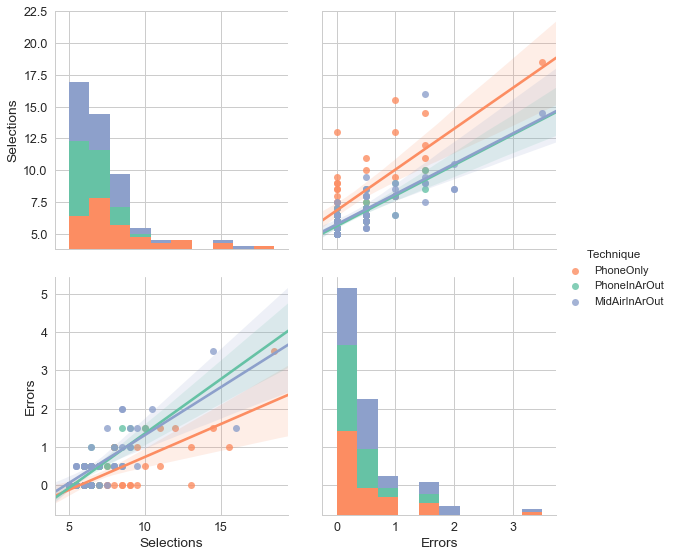

In [61]:
g = sns.pairplot(trials, hue=technique['label'], kind='reg',
                 vars=[trials_dvs['selections_count'], trials_dvs['errors']],
                 palette=technique['palette'], size=4);
g.savefig('selections_errors_distributions.png')

It seems that a user makes as much errors as she makes selections. The relation is almost the same for each technique, even if users seems to make more selections for the same number of errors with PhoneOnly. 

We can't use ANOVA on SELECTIONS and ERRORS variables as their distributions are exponentials. We use instead the Kruskal-Wallis test (Benjamini–Hochberg correction) to check if there is significative differences due to TECHNIQUE, TEXT_SIZE, DISTANCE or ORDERING.

In [62]:
test_non_normal_trials(['technique', 'text_size', 'distance', 'ordering'],
                       ['selections_count', 'errors'])

,IV,DV,Kruskal-Wallis H,p-value
0,Technique,Selections,15.125918,0.004155
1,Text Size,Selections,0.003897,0.950224
2,Distance,Selections,0.052701,0.935347
3,Ordering,Selections,11.510535,0.010095
4,Technique,Errors,5.201541,0.148433
5,Text Size,Errors,0.103661,0.935347
6,Distance,Errors,0.201599,0.935347
7,Ordering,Errors,11.153096,0.010095


Only TECHNIQUE ($p=0.004$) and ORDERING ($p=0.01$) have a significant effect on SELECTIONS. But, only ORDERING ($p=0.01$) have a significant effect on ERRORS.

We use then pairwise Mann-Whitney tests (Benjamini–Hochberg correction) for the significant questions above:

In [63]:
test_pairwise_non_normal_trials(['technique', 'ordering'],
                                ['selections_count', 'errors'])

,IV,IV Value 1,IV Value 2,DV,Mean Difference,Mean Difference Percentage,Mann-Whitney U,p-value
0,Technique,PhoneOnly,PhoneInArOut,Selections,1.864583,29.537954,627.0,0.000635
1,Technique,PhoneOnly,MidAirInArOut,Selections,1.041667,14.598540,864.5,0.029356
2,Technique,PhoneInArOut,MidAirInArOut,Selections,-0.822917,-11.532847,915.0,0.059881
3,Ordering,Group 1,Group 2,Selections,1.729167,26.265823,755.0,0.005196
4,Ordering,Group 1,Group 3,Selections,1.583333,23.529412,755.0,0.005196
5,Ordering,Group 2,Group 3,Selections,-0.145833,-2.167183,1136.0,0.454285
6,Technique,PhoneOnly,PhoneInArOut,Errors,0.125000,42.857143,1083.5,0.312007
7,Technique,PhoneOnly,MidAirInArOut,Errors,-0.166667,-28.571429,957.0,0.083050
8,Technique,PhoneInArOut,MidAirInArOut,Errors,-0.291667,-50.000000,873.0,0.026306
9,Ordering,Group 1,Group 2,Errors,0.333333,103.225806,846.5,0.020183


In [64]:
trial_means(['technique'], ['selections_count', 'errors'])

,Selections,Errors
Technique,,
PhoneOnly,"8.18 [7.42, 9.06]","0.42 [0.24, 0.61]"
PhoneInArOut,"6.31 [5.97, 6.66]","0.29 [0.18, 0.42]"
MidAirInArOut,"7.14 [6.55, 7.84]","0.58 [0.39, 0.80]"


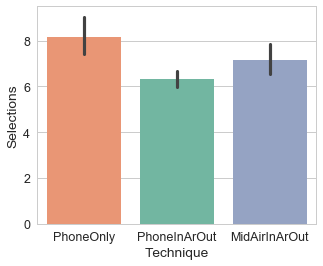

In [65]:
(fig, axs) = plot_trials([['technique']], 'selections_count')
fig.savefig('selections.png')

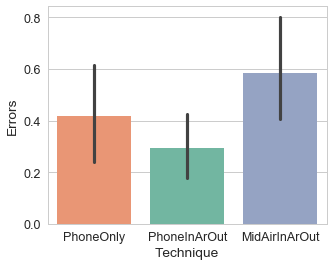

In [66]:
(fig, axs) = plot_trials([['technique']], 'errors')
fig.savefig('errors.png')

In [67]:
trial_means(['ordering', 'technique'], ['selections_count', 'errors'])

Selections             Errors
Ordering Technique                                            
Group 1  PhoneOnly      10.44 [8.66, 12.41]  0.81 [0.41, 1.31]
         PhoneInArOut     6.88 [6.34, 7.47]  0.44 [0.22, 0.69]
         MidAirInArOut    7.62 [6.56, 8.94]  0.72 [0.41, 1.03]
Group 2  PhoneOnly        6.75 [6.22, 7.31]  0.22 [0.06, 0.41]
         PhoneInArOut     6.53 [5.91, 7.22]  0.38 [0.16, 0.59]
         MidAirInArOut    6.47 [5.88, 7.09]  0.38 [0.16, 0.59]
Group 3  PhoneOnly        7.34 [6.66, 8.06]  0.22 [0.06, 0.41]
         PhoneInArOut     5.53 [5.22, 5.88]  0.06 [0.00, 0.16]
         MidAirInArOut    7.31 [6.34, 8.56]  0.66 [0.25, 1.16]

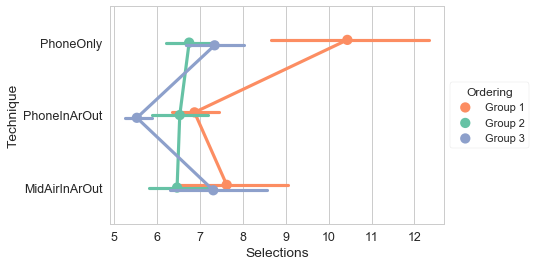

In [68]:
ax = sns.pointplot(x=trials_dvs['selections_count'], y=technique['label'],
                   hue=ordering['label'], palette=ordering['palette'],
                   data=trials, dodge=True)
config_legend(ax, 'ordering')
ax.get_figure().savefig('selections_ordering.png')

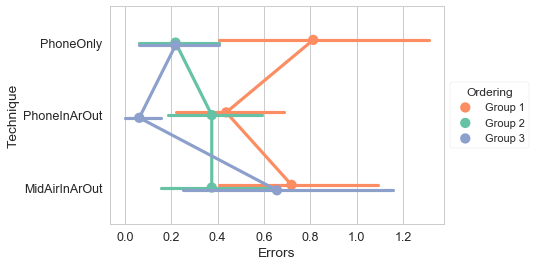

In [69]:
ax = sns.pointplot(x=trials_dvs['errors'], y=technique['label'],
                   hue=ordering['label'], palette=ordering['palette'],
                   data=trials, dodge=True)
config_legend(ax, 'ordering')
ax.get_figure().savefig('errors_ordering.png')

### 3.3. Navigation

Variable meanings:

- Selection Time = time spent looking for where to drop an item that had been picked
- Selection Distance = distance travelled by the finger with an item selected
- Head Phone Distance = sum of the distance between the head and the phone

In [70]:
# Data preparation
trial_counts = melt_trials(var_name=labels['category'],
                           value_name=labels['count'], 
                           value_vars=[trials_dvs['pan_count'],
                                      trials_dvs['zoom_count']])

trial_times = melt_trials(var_name=labels['category'],
                          value_name=labels['time'],
                          value_vars=[trials_dvs['selections_time'],
                                      trials_dvs['pan_time'],
                                      trials_dvs['zoom_time']])

trial_distances_dvs = [trials_dvs['selections_projected_distance'],
                       trials_dvs['pan_projected_distance'],
                       trials_dvs['zoom_projected_distance'],
                       trials_dvs['absolute_head_phone_distance']]
trial_distances = melt_trials(var_name=labels['category'],
                              value_name=labels['distance'],
                              value_vars=trial_distances_dvs)

In [71]:
trial_means(['technique'], ['pan_count', 'zoom_count'])

,Pans,Zooms
Technique,,
PhoneOnly,"28.70 [24.13, 34.34]","15.53 [13.57, 17.52]"
PhoneInArOut,"31.81 [26.75, 37.24]","7.14 [5.64, 8.65]"
MidAirInArOut,"1.83 [0.78, 3.10]","0.83 [0.27, 1.50]"


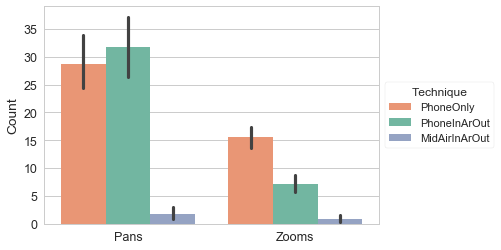

In [72]:
ax = sns.barplot(x=labels['category'], y=labels['count'],
                 hue=technique['label'], palette=technique['palette'],
                 data=trial_counts)
config_legend(ax, 'technique')
ax.set(xlabel='')
ax.get_figure().savefig('navigation_count.png')

In [73]:
trial_means(['technique'], ['selections_time', 'pan_time', 'zoom_time'])

,Selection Time,Pan Time,Zoom Time
Technique,,,
PhoneOnly,"55.74 [49.90, 61.91]","17.12 [14.51, 20.05]","15.18 [13.24, 17.09]"
PhoneInArOut,"38.98 [34.07, 43.97]","14.53 [12.49, 16.68]","6.70 [5.02, 8.65]"
MidAirInArOut,"69.68 [61.15, 79.08]","5.97 [2.27, 10.49]","6.24 [1.48, 11.96]"


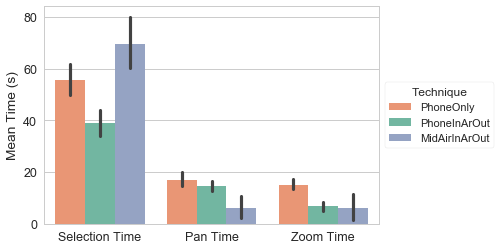

In [74]:
ax = sns.barplot(x=labels['category'], y=labels['time'], data=trial_times,
                 hue=technique['label'], palette=technique['palette'])
config_legend(ax, 'technique')
ax.set(xlabel='')
ax.get_figure().savefig('navigation_time.png')

In [75]:
trial_means(['technique'], ['selections_projected_distance',
                            'pan_projected_distance',
                            'zoom_projected_distance',
                            'absolute_head_phone_distance'])

,Selection Distance on Grid,Pan Distance on Grid,Zoom Distance on Grid,Phone-Head Motion
Technique,,,,
PhoneOnly,"4.87 [4.04, 5.80]","1.50 [1.20, 1.82]","2.11 [1.74, 2.59]","3.18 [2.35, 4.14]"
PhoneInArOut,"2.83 [2.37, 3.31]","1.09 [0.90, 1.30]","0.69 [0.50, 0.91]","1.57 [1.25, 1.94]"
MidAirInArOut,"8.72 [7.16, 10.56]","0.47 [0.19, 0.81]","0.62 [0.15, 1.24]","6.12 [4.80, 7.51]"


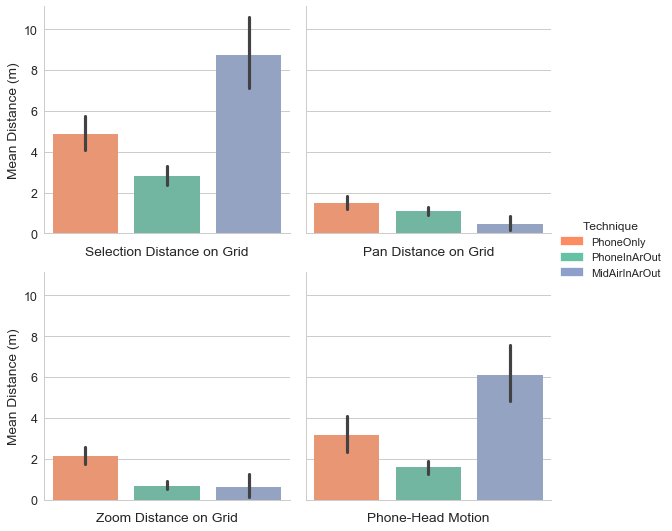

In [76]:
g = sns.factorplot(x=technique['label'], y=labels['distance'],
                   col=labels['category'], data=trial_distances,
                   palette=technique['palette'], kind='bar', col_wrap=2)

g.set_titles('{col_name}') # Replace subplot titles
for ax in g.axes:
    ax.title.set_position([0.5, -0.12])

g.set_axis_labels('') # Custom legend
g.set_xticklabels([])
legend_handles = [patches.Patch(color=color, label=value)\
                  for value, color in zip(technique['categorical'],
                                          technique['palette'])]
legend = plt.legend(handles=legend_handles, loc='center left',
                    bbox_to_anchor=(1, 1.1), title=technique['label'])
fix_legend_fontsize(legend)

g.savefig('navigation_distance.png')